In [1]:
import numpy as np
import secrets
from ase.io import read
import package_files.data_generator as dg
import matplotlib.pyplot as plt
%matplotlib ipympl

In [2]:
# Read in xtal
xtal_l1 = read(filename = './cif_files/MoS2_l1.cif')
xtal_l2 = read(filename = './cif_files/MoS2_l2.cif')
combined_xtal = xtal_l1 + xtal_l2
positions = combined_xtal.get_positions()[:, :2]
xmin, xmax = np.min(positions[:, 0]), np.max(positions[:, 0])
ymin, ymax = np.min(positions[:, 1]), np.max(positions[:, 1])
borders = 1
axis_extent = (xmin - borders, xmax + borders, ymin - borders, ymax + borders)

In [3]:
# Generate training dataset
n_images = 100
crop_size = 512
pixel_size = 0.078125 # Angstrom/pixel, determines number of points, aka resolution of maps.  the xtal determines the fov
n_crops = 20 # number of 512 crops per large image

In [66]:
# Set numpy randomizer
used_seeds = []
master_seed = secrets.randbits(128)
while master_seed in used_seeds:
    master_seed = secrets.randbits(128)
used_seeds.append(master_seed)
rng = np.random.default_rng(master_seed)

# Set random params
# --------------------------------------------------
phonon_sigma = rng.uniform(0.05, 0.15)
rotation_l1 = rng.uniform(0, 360)
rotation_l2 = rotation_l1 + rng.choice([0, 0, 0, 60, 120, 240])
atom_var = rng.normal(loc = 0.175, scale = 0.01)
airy_disk_size = 1
shot_noise = rng.uniform(0.6, 0.9)
magnification_var = rng.uniform(0.2, 0.35)
crop_param_seed = rng.integers(0, 1000000)

In [67]:
# Make xtal (with random rotations and vacancies)
rot_xtal_l1 = dg.get_imaging_xtal(xtal = xtal_l1, n_cells = (1,1,1), rotation = rotation_l1, n_vacancies = 10, phonon_sigma = phonon_sigma, axis_extent = axis_extent)
rot_xtal_l2 = dg.get_imaging_xtal(xtal = xtal_l2, n_cells = (1,1,1), rotation = rotation_l2, n_vacancies = 10, phonon_sigma = phonon_sigma, axis_extent = axis_extent)


In [68]:
# Make potential and psf (with random atom_size and psf size)
potential_l1 = dg.get_pseudo_potential_beta(xtal = rot_xtal_l1, pixel_size = pixel_size, sigma = 1/atom_var, axis_extent = axis_extent)
potential_l2 = dg.get_pseudo_potential_beta(xtal = rot_xtal_l2, pixel_size = pixel_size, sigma = 1/atom_var, axis_extent = axis_extent)
# Normalize potentials and add
potential_l1, potential_l2 = potential_l1 / np.max(potential_l1), potential_l2 / np.max(potential_l2)
potential_total = potential_l1 + potential_l2

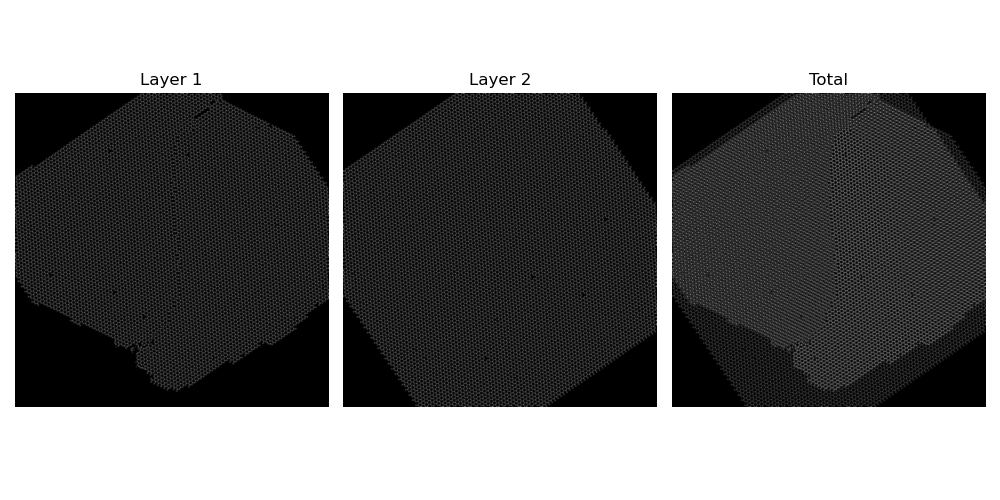

In [69]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 5))
ax[0].imshow(potential_l1, cmap='gray')
ax[0].set_title('Layer 1')
ax[1].imshow(potential_l2, cmap='gray')
ax[1].set_title('Layer 2')
ax[2].imshow(potential_total, cmap='gray')
ax[2].set_title('Total')

for ax in ax:
    ax.axis('off')
fig.tight_layout()

In [70]:
# Make point spread function
psf = dg.get_point_spread_function(airy_disk_radius = airy_disk_size, size = 32)
psf_resize = dg.resize_image(np.array(psf), n = max(potential_total.shape)) # for plotting on same axes as image


In [71]:
# Make image, masks and add shot noise
perfect_image = dg.make_image(potential_total, psf)
noisy_image = dg.add_poisson_noise(perfect_image, shot_noise = shot_noise)
masks_l1 = dg.get_onehot_masks(rot_xtal_l1, axis_extent = axis_extent, pixel_size = pixel_size, radius = 5)
masks_l2 = dg.get_onehot_masks(rot_xtal_l2, axis_extent = axis_extent, pixel_size = pixel_size, radius = 5)


Text(0.5, 1.0, 'PSF')

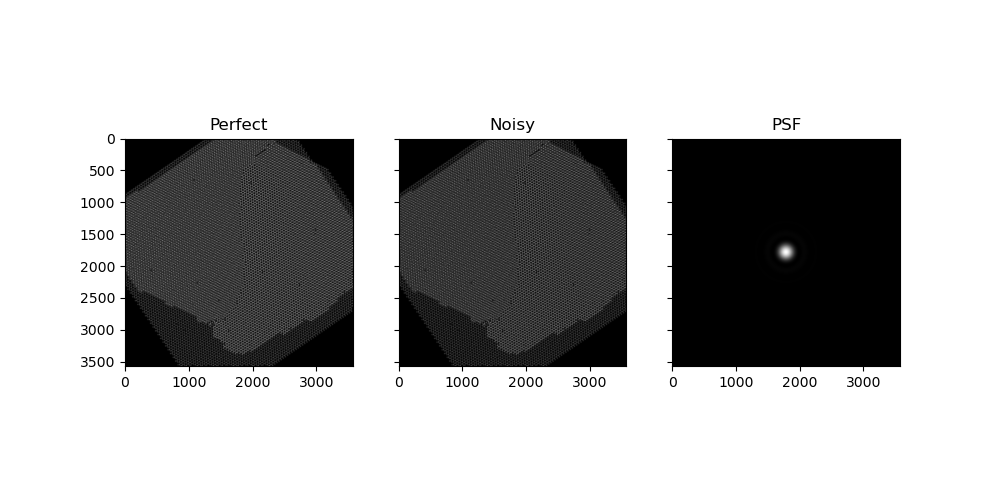

In [72]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 5))
ax[0].imshow(perfect_image, cmap='gray')
ax[0].set_title('Perfect')
ax[1].imshow(noisy_image, cmap='gray')
ax[1].set_title('Noisy')
ax[2].imshow(psf_resize, cmap='gray')
ax[2].set_title('PSF')

In [112]:
# Crop and zoom
batch_ims = dg.shotgun_crop(noisy_image, crop_size = 512, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, roi = 'middle')
batch_ims = batch_ims.reshape(-1,crop_size,crop_size)

batch_masks_l1 = dg.shotgun_crop(masks_l1, crop_size = 512, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, return_binary = True, roi = 'middle')
batch_masks_l2 = dg.shotgun_crop(masks_l2, crop_size = 512, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, return_binary = True, roi = 'middle')
batch_masks = np.stack((batch_masks_l1, batch_masks_l2), axis=1)
batch_masks = batch_masks.reshape(-1,len(masks_l1)+len(masks_l2),crop_size,crop_size)
batch_masks = (batch_masks > 0.5).astype(int) # binarize the masks